In [18]:
import os
import iris
import numpy as np
import pandas as pd
import iris
import iris.analysis
import iris.quickplot as qplt
from iris.cube import CubeList
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
import iris.plot as iplt

shapefile = gpd.read_file('/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Data/Limpopo/Limpopo_Boundaries.geojson')
print('Shapefile loaded')

# outline_shapefile = gpd.read_file('/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Data/Limpopo/Limpopo_Outline.geojson')

Shapefile loaded


In [19]:
# Loading baseline data
CMIP6_baseline = iris.load_cube('/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/scaled_CMIP6_ERA5_heat_index_1995_2014.nc')
CORDEX_baseline = iris.load_cube('/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/scaled_CORDEX_ERA5_heat_index_1995_2014.nc')

# Masking the baseline data
# CMIP6_baseline = iris.util.mask_cube_from_shapefile(CMIP6_baseline, limpopo_outline.geometry[0], minimum_weight=0.3)
# CORDEX_baseline = iris.util.mask_cube_from_shapefile(CORDEX_baseline, limpopo_outline.geometry[0], minimum_weight=0.3)

/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/__init__.py:354: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = _load_collection(uris, constraints, callback).cubes()


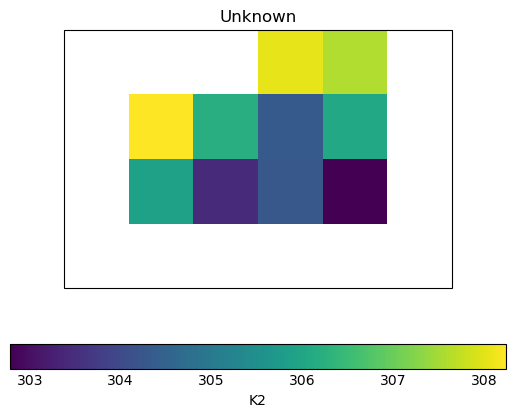

In [22]:
qplt.pcolormesh(CMIP6_baseline[0])

In [32]:
CMIP6_2041_2060_cubelist = iris.cube.CubeList([])
CMIP6_2080_2099_cubelist = iris.cube.CubeList([])

CORDEX_2041_2060_cubelist = iris.cube.CubeList([])
CORDEX_2080_2099_cubelist = iris.cube.CubeList([])

filepaths = [
    '/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CMIP6/2041_2060',
    '/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CMIP6/2080_2099',
    '/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CORDEX/2041_2060',
    '/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CORDEX/2080_2099'
]

cubelists = [
    CMIP6_2041_2060_cubelist,
    CMIP6_2080_2099_cubelist,
    CORDEX_2041_2060_cubelist,
    CORDEX_2080_2099_cubelist
]

def load_and_append_projection_cubes(filepath, cubelist):
    files = []
    try:
        files = os.listdir(filepath)
        print(f"Files in {filepath} loaded")
    except Exception as e:
        print(f"Error loading files in {filepath}: {e}")
    for file in files:
        try:
            cube = iris.load_cube(f'{filepath}/{file}')
            # cube.convert_units('Kelvin')
            # cube = iris.util.mask_cube_from_shapefile(cube, limpopo_outline.geometry[0], minimum_weight=0.3)
            cubelist.append(cube)
        except Exception as e:
            print(f"Error loading cube from {file}: {e}")
    return cubelist

for filepath, cubelist in zip(filepaths, cubelists):
    load_and_append_projection_cubes(filepath, cubelist)

Files in /Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CMIP6/2041_2060 loaded
Files in /Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CMIP6/2080_2099 loaded
Files in /Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CORDEX/2041_2060 loaded
Files in /Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Python_code/Projections_data/Scaled_New/CORDEX/2080_2099 loaded


# Maps

## Heat index difference

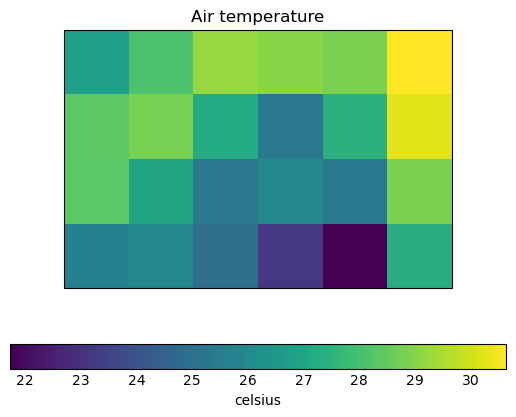

In [33]:
qplt.pcolormesh(CMIP6_2041_2060_map)

In [50]:
CMIP6_baseline_map = CMIP6_baseline.aggregated_by('season_year', iris.analysis.MEAN)
CMIP6_baseline_map = CMIP6_baseline_map.collapsed('time', iris.analysis.MEAN)

CORDEX_baseline_map = CORDEX_baseline.aggregated_by('season_year', iris.analysis.MEAN)
CORDEX_baseline_map = CORDEX_baseline_map.collapsed('time', iris.analysis.MEAN)

def create_average_model_map(cubelist):
    # Calculate the temporal mean of each cube in the CubeList
    # Aggregate each cube by 'season_year' and calculate the mean
    yearly_mean_cubes = iris.cube.CubeList([cube.aggregated_by('season_year', iris.analysis.MEAN) for cube in cubelist])

    # Collapse each cube in the yearly_mean_cubes list over the 'time' dimension to calculate the mean of the daily max values per year
    mean_cubes = iris.cube.CubeList([cube.collapsed('time', iris.analysis.MEAN) for cube in yearly_mean_cubes])

    # Remove conflicting attributes, scalar coordinates, and cell methods from each cube that otherwise cause the merge to fail (found through trial and error with each run outputting new conflicting attributes and alike in the output)
    for cube in mean_cubes:
        cube.attributes = {}
        for coord in ['time', 'day_of_month', 'height', 'month', 'season', 'season_year', 'year', 'day_of_year']:
            if cube.coords(coord):
                cube.remove_coord(coord)
        cube.cell_methods = ()

    # Regrid all cubes to the grid of the first cube in the list
    cube_to_regrid_to = mean_cubes[0]
    regridded_cubes = iris.cube.CubeList([cube.regrid(cube_to_regrid_to, iris.analysis.Linear()) for cube in mean_cubes])

    # Add a new dimension to each cube to 'stack' them
    for i, cube in enumerate(regridded_cubes):
        cube.add_aux_coord(iris.coords.AuxCoord(i, long_name='model_index'))

    # Merge the cubes into a single cube ('stacked')
    stacked_cube = regridded_cubes.merge_cube()

    # Calculate the mean across the new dimension
    average_cube = stacked_cube.collapsed('model_index', iris.analysis.MEAN)

    return average_cube

# Average maps
CMIP6_2041_2060_map = create_average_model_map(CMIP6_2041_2060_cubelist)
CMIP6_2080_2099_map = create_average_model_map(CMIP6_2080_2099_cubelist)

CORDEX_2041_2060_map = create_average_model_map(CORDEX_2041_2060_cubelist)
CORDEX_2080_2099_map = create_average_model_map(CORDEX_2080_2099_cubelist)

# Difference maps
CMIP6_2041_2060_diff = CMIP6_2041_2060_map - CMIP6_baseline_map
CMIP6_2080_2099_diff = CMIP6_2080_2099_map - CMIP6_baseline_map

CORDEX_2041_2060_diff = CORDEX_2041_2060_map - CORDEX_baseline_map
CORDEX_2080_2099_diff = CORDEX_2080_2099_map - CORDEX_baseline_map

/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warning

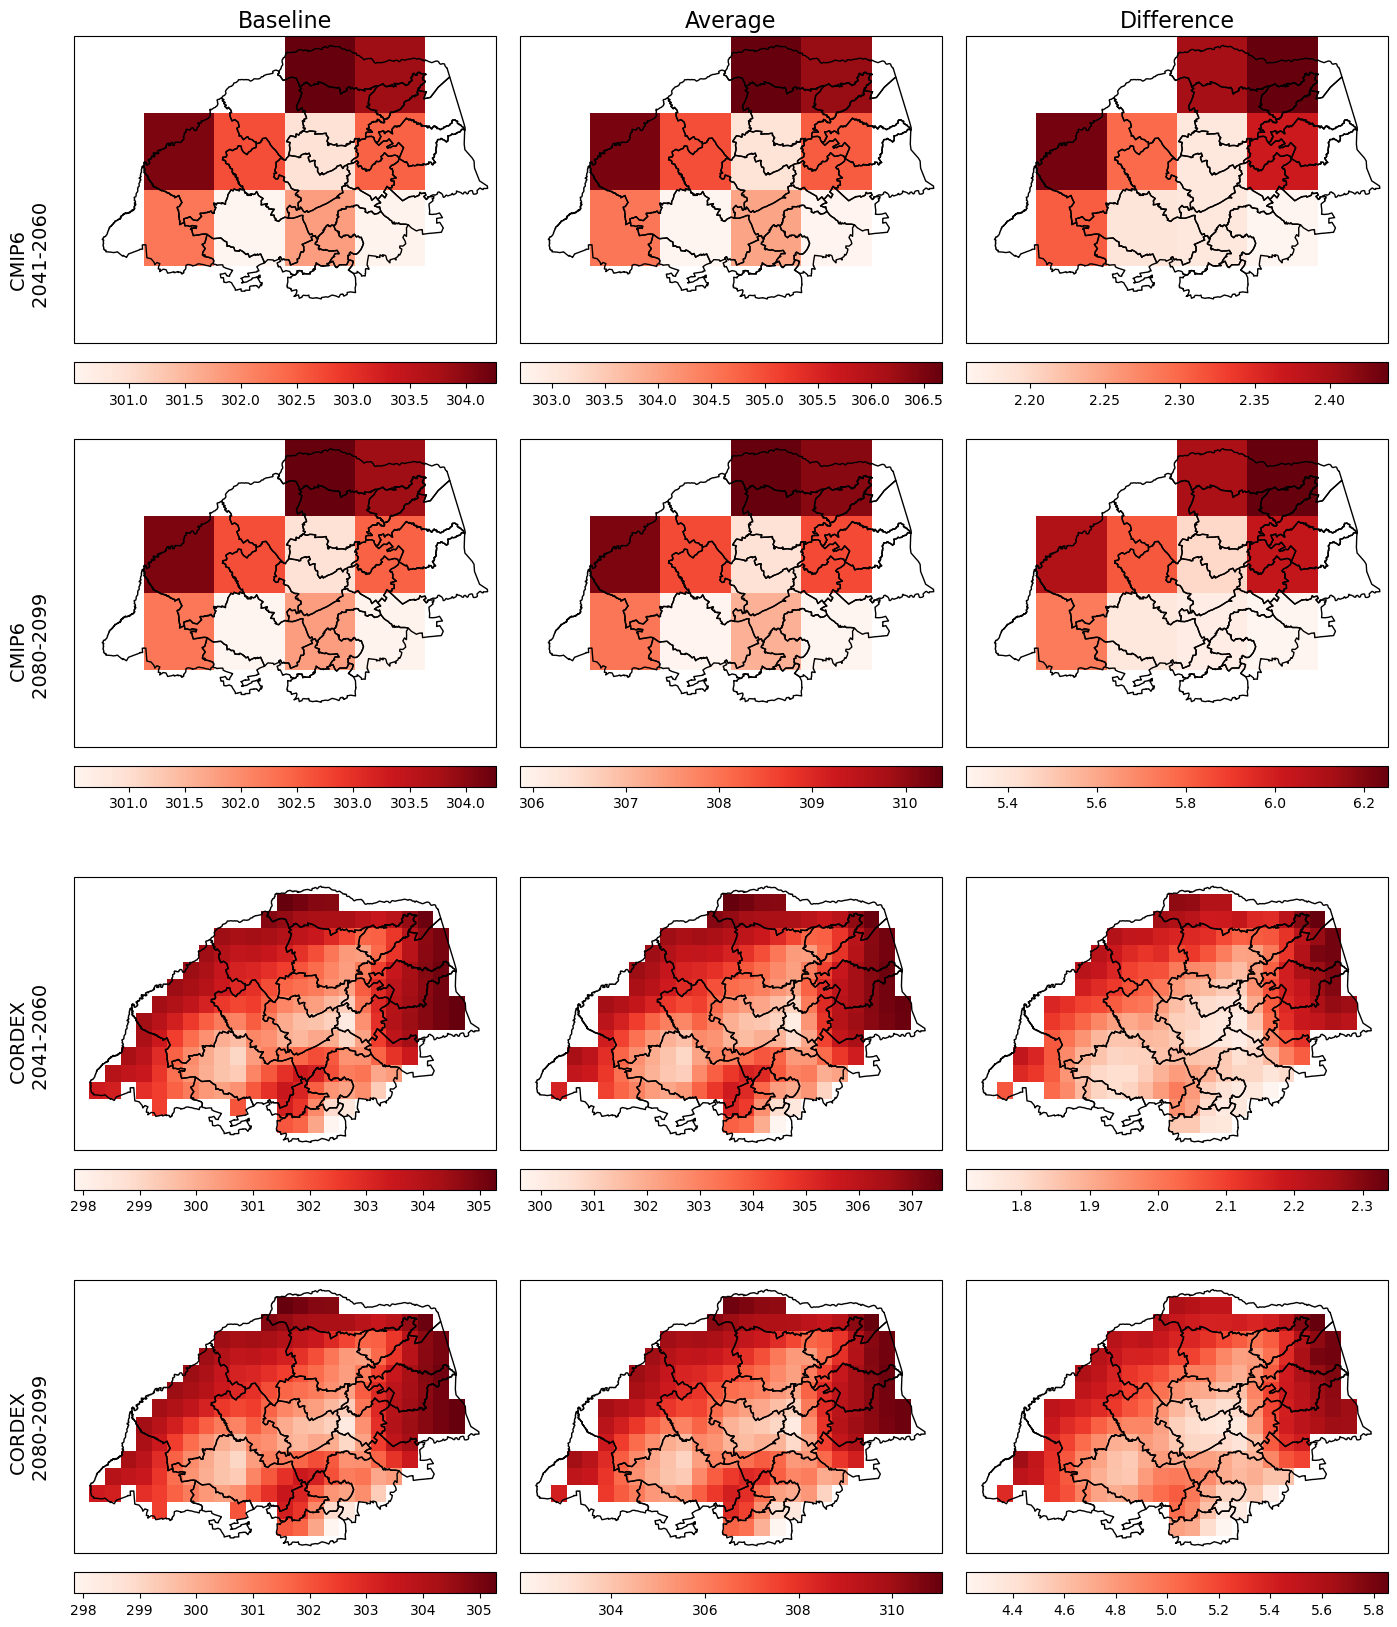

Color bar 1 range: 300.5089431811286 to 304.2683799903798
Color bar 2 range: 302.69354274929896 to 306.6713236748526
Color bar 3 range: 2.157304889258455 to 2.438750322625367
Color bar 4 range: 300.5089431811286 to 304.2683799903798
Color bar 5 range: 305.86272787895365 to 310.3876622370488
Color bar 6 range: 5.305675725228127 to 6.25375894157645
Color bar 7 range: 297.83195703114336 to 305.28779426082446
Color bar 8 range: 299.60540945597336 to 307.5726654827453
Color bar 9 range: 1.7184269554518323 to 2.33729541725927
Color bar 10 range: 297.83195703114336 to 305.28779426082446
Color bar 11 range: 302.0503470664218 to 311.05633005007644
Color bar 12 range: 4.218390035278446 to 5.855673894426559


In [51]:
# Create a figure with 3 columns and 5 rows
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 23), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the models and their corresponding maps
models = [
    ("CMIP6 2041-2060", CMIP6_baseline_map, CMIP6_2041_2060_map, CMIP6_2041_2060_diff),
    ("CMIP6 2080-2099", CMIP6_baseline_map, CMIP6_2080_2099_map, CMIP6_2080_2099_diff),
    ("CORDEX 2041-2060", CORDEX_baseline_map, CORDEX_2041_2060_map, CORDEX_2041_2060_diff),
    ("CORDEX 2080-2099", CORDEX_baseline_map, CORDEX_2080_2099_map, CORDEX_2080_2099_diff)
]

# Column titles
column_titles = ['Baseline', 'Average', 'Difference']

# Store color bars to print their ranges later
colorbars = []

# Plot each category of maps using a for loop on rows and the contents of the 'models' list
for row, (model_name, baseline_map, average_map, difference_map) in enumerate(models):
    # Plot baseline map
    plt.sca(axes[row, 0])
    baseline_plot = iplt.pcolormesh(baseline_map, axes=axes[row, 0], cmap='Reds')
    shapefile.plot(ax=axes[row, 0], color='none', edgecolor='black', linewidth=1)  # Add shapefile to the plot
    if row == 0:
        axes[row, 0].set_title(column_titles[0], fontsize=16)
    cbar = fig.colorbar(baseline_plot, ax=axes[row, 0], orientation='horizontal', pad=0.02)
    colorbars.append(cbar)

    # Plot average map
    plt.sca(axes[row, 1])
    average_plot = iplt.pcolormesh(average_map, axes=axes[row, 1], cmap='Reds')
    if row == 0:
        axes[row, 1].set_title(column_titles[1], fontsize=16)
    shapefile.plot(ax=axes[row, 1], color='none', edgecolor='black', linewidth=1)  # Add shapefile to the plot
    cbar = fig.colorbar(average_plot, ax=axes[row, 1], orientation='horizontal', pad=0.02)
    colorbars.append(cbar)

    # Plot difference map but with different colourmaps for CMIP6 and CORDEX as CMIP6 has negative differences
    plt.sca(axes[row, 2])
    if row == 0:
        difference_plot = iplt.pcolormesh(difference_map, axes=axes[row, 2], cmap='Reds')
        axes[row, 2].set_title(column_titles[2], fontsize=16)
    else:
        difference_plot = iplt.pcolormesh(difference_map, axes=axes[row, 2], cmap='Reds')
    shapefile.plot(ax=axes[row, 2], color='none', edgecolor='black', linewidth=1)  # Add shapefile to the plot
    cbar = fig.colorbar(difference_plot, ax=axes[row, 2], orientation='horizontal', pad=0.02)
    colorbars.append(cbar)

# Add row labels using fig.text for better control
row_labels = [f'CMIP6 \n 2041-2060', f'CMIP6 \n 2080-2099', f'CORDEX \n 2041-2060', f'CORDEX \n 2080-2099']
for row, label in enumerate(row_labels):
    fig.text(0.085, 0.64 - row * 0.17, label, va='center', ha='center', rotation='vertical', fontsize=14) # Note to self: initial y value is FROM THE BOTTOM

# Adjust layout
plt.subplots_adjust(hspace=-0.65)  # Use a negative value for hspace to reduce the space between subplots
plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()

# Print color bar ranges
for i, cbar in enumerate(colorbars):
    print(f"Color bar {i+1} range: {cbar.vmin} to {cbar.vmax}")

## Proportion of days per year

In [38]:
def compute_average_days_above_threshold_per_year(cube, threshold):
    """
    Compute the average number of days per year above the given threshold for each cell in the cube.
    
    Args:
        cube (iris.Cube): The input data cube.
        threshold (float): The threshold value.
        
    Returns:
        iris.Cube: A cube containing the average number of days per year above the threshold for each cell.
    """
    # Initialize a list to store the proportion of days above the threshold for each year
    proportions = []
    
    # Iterate over each year
    for year in np.unique(cube.coord('year').points):
        # Extract data for the current year
        year_constraint = iris.Constraint(year=year)
        cube_year = cube.extract(year_constraint)
        
        # Compute the total number of days in the current year for each cell
        total_days = cube_year.shape[0]
        
        # Compute the number of days above the threshold in the current year for each cell
        days_above_threshold = np.sum(cube_year.data > threshold, axis=0)
        
        # Compute the proportion of days above the threshold in the current year
        proportion_above_threshold = days_above_threshold / total_days
        
        # Append the proportion to the list
        proportions.append(proportion_above_threshold)
    
    # Convert the list of proportions to a numpy array
    proportions = np.array(proportions)
    
    # Compute the mean proportion over all years
    mean_proportion_above_threshold = np.mean(proportions, axis=0)
    
    # Convert the mean proportion to a percentage
    mean_proportion_above_threshold *= 100 # Shorthand for mean_proportion_above_threshold = mean_proportion_above_threshold * 100
    
    # Mask the invalid data and zero values
    mean_proportion_above_threshold = np.ma.masked_where(mean_proportion_above_threshold == 0, mean_proportion_above_threshold)
    
    # Create a new cube to store the mean proportion
    mean_proportion_cube = cube[0].copy(data=mean_proportion_above_threshold)
    
    return mean_proportion_cube

/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_month', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_month'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be ful

[298.44, 307.90890823707883, 308.62554672562203, 309.64010609214614]
[298.44, 309.54063713183643, 310.4661056802314, 311.7889002821526]


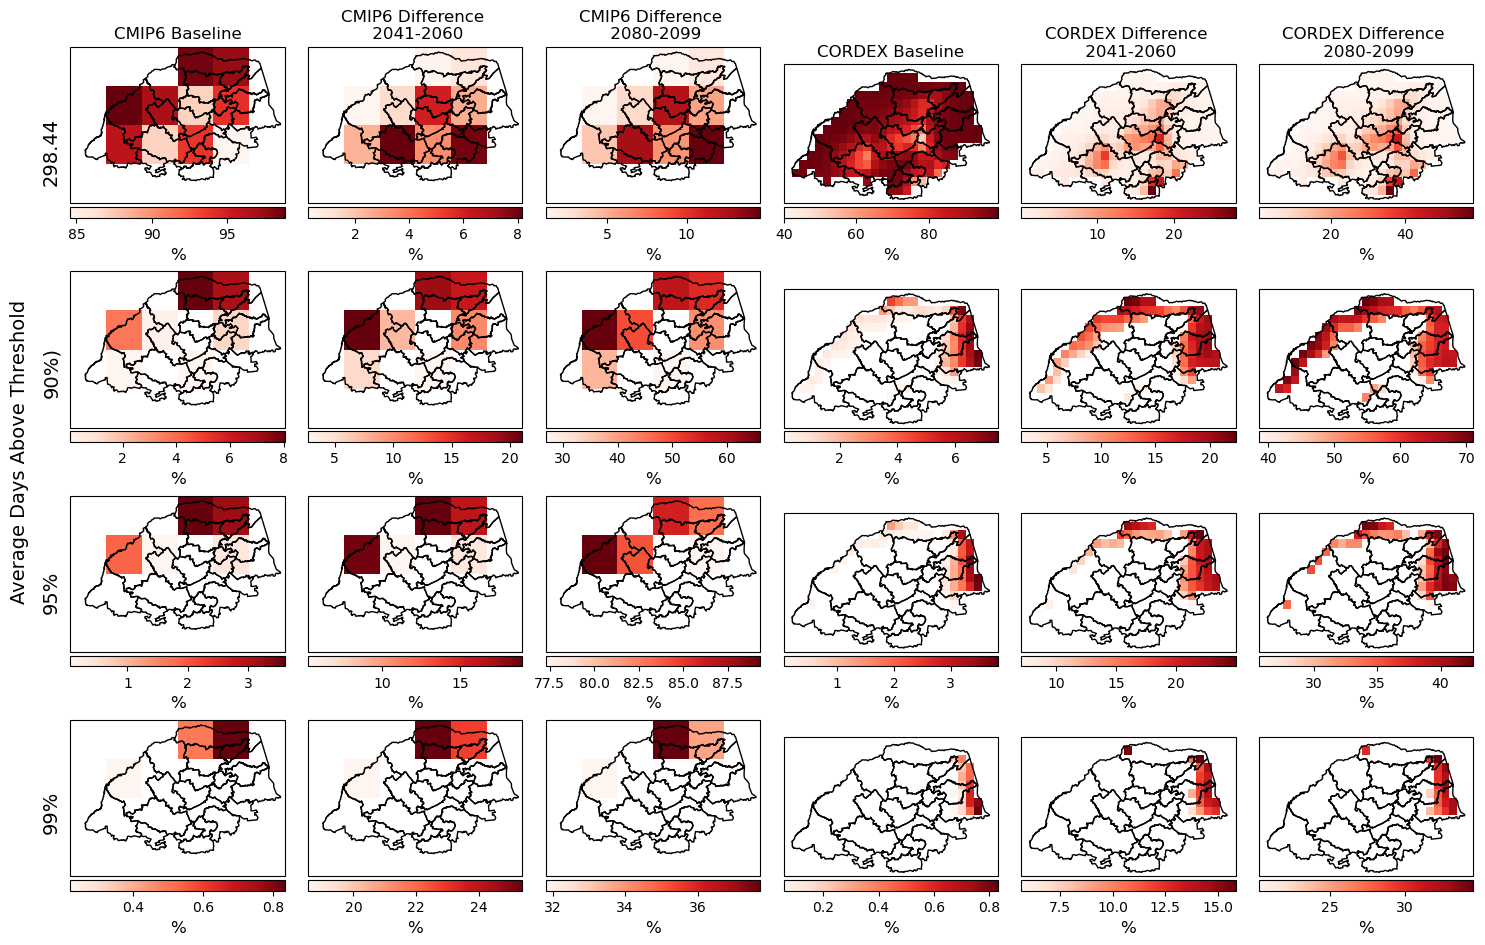

Color bar 1 range: 84.60256410256413 to 98.84004884004884
Color bar 2 range: 0.2710622710622772 to 8.176434676434667
Color bar 3 range: 1.159951159951163 to 14.619658119658084
Color bar 4 range: 39.859584859584864 to 99.17032967032966
Color bar 5 range: 0.1630036630036784 to 27.97374847374848
Color bar 6 range: 0.8296703296703356 to 58.25396825396823
Color bar 7 range: 0.05555555555555555 to 8.04212454212454
Color bar 8 range: 2.722222222222222 to 21.062271062271066
Color bar 9 range: 26.86996336996337 to 66.03846153846155
Color bar 10 range: 0.05555555555555555 to 7.4853479853479845
Color bar 11 range: 2.659340659340659 to 22.379120879120876
Color bar 12 range: 38.57448107448108 to 71.03296703296704
Color bar 13 range: 0.05555555555555555 to 3.606837606837606
Color bar 14 range: 5.258852258852258 to 18.985958485958488
Color bar 15 range: 77.29242979242981 to 89.31257631257631
Color bar 16 range: 0.05555555555555555 to 3.8278388278388267
Color bar 17 range: 7.088522588522589 to 24.9340

In [46]:
# Load the shapefile
shapefile = gpd.read_file('/Users/maxwhite/Documents/Met_Office_Work/Heat_index_Algorithms/Data/Limpopo/Limpopo_Boundaries.geojson')

# Calculate the 90th, 95th, and 99th percentiles for each baseline cube
baseline_cube_CMIP6_counts = CMIP6_baseline.copy()
baseline_cube_CORDEX_counts = CORDEX_baseline.copy()

CMIP6_thresholds = []
CORDEX_thresholds = []

# Calculate the thresholds for each baseline cube
for cube, thresholds in zip([baseline_cube_CMIP6_counts, baseline_cube_CORDEX_counts], [CMIP6_thresholds, CORDEX_thresholds]):
    daily_max = cube.collapsed(['latitude', 'longitude'], iris.analysis.MAX)
    thresholds.append(float(298.44))
    thresholds.append(float(daily_max.collapsed('time', iris.analysis.PERCENTILE, percent=90).data))
    thresholds.append(float(daily_max.collapsed('time', iris.analysis.PERCENTILE, percent=95).data))
    thresholds.append(float(daily_max.collapsed('time', iris.analysis.PERCENTILE, percent=99).data))
    print(thresholds)

# Compute the average number of days above the thresholds for each year
CMIP6_2041_2060_counts = [compute_average_days_above_threshold_per_year(cube, threshold) for cube, threshold in zip(CMIP6_2041_2060_cubelist, CMIP6_thresholds)]
CMIP6_2080_2099_counts = [compute_average_days_above_threshold_per_year(cube, threshold) for cube, threshold in zip(CMIP6_2080_2099_cubelist, CMIP6_thresholds)]
CORDEX_2041_2060_counts = [compute_average_days_above_threshold_per_year(cube, threshold) for cube, threshold in zip(CORDEX_2041_2060_cubelist, CORDEX_thresholds)]
CORDEX_2080_2099_counts = [compute_average_days_above_threshold_per_year(cube, threshold) for cube, threshold in zip(CORDEX_2080_2099_cubelist, CORDEX_thresholds)]

# Compute the baseline counts
baseline_CMIP6_counts = [compute_average_days_above_threshold_per_year(baseline_cube_CMIP6_counts, threshold) for threshold in CMIP6_thresholds]
baseline_CORDEX_counts = [compute_average_days_above_threshold_per_year(baseline_cube_CORDEX_counts, threshold) for threshold in CORDEX_thresholds]

# Calculate the differences in the counts of days above each threshold
CMIP6_2041_2060_counts_difference = [count - baseline for count, baseline in zip(CMIP6_2041_2060_counts, baseline_CMIP6_counts)]
CMIP6_2080_2099_counts_difference = [count - baseline for count, baseline in zip(CMIP6_2080_2099_counts, baseline_CMIP6_counts)]
CORDEX_2041_2060_counts_difference = [count - baseline for count, baseline in zip(CORDEX_2041_2060_counts, baseline_CORDEX_counts)]
CORDEX_2080_2099_counts_difference = [count - baseline for count, baseline in zip(CORDEX_2080_2099_counts, baseline_CORDEX_counts)]

# Create a figure with 6 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
column_titles = ['CMIP6 Baseline', 'CMIP6 Difference \n 2041-2060', 'CMIP6 Difference \n 2080-2099', 'CORDEX Baseline', 'CORDEX Difference \n 2041-2060', 'CORDEX Difference \n 2080-2099']
row_labels = ['298.44', '90th Percentile', '95th Percentile', '99th Percentile']

# Define the data to be plotted
data_to_plot = [
    baseline_CMIP6_counts[0], CMIP6_2041_2060_counts_difference[0], CMIP6_2080_2099_counts_difference[0],
    baseline_CORDEX_counts[0], CORDEX_2041_2060_counts_difference[0], CORDEX_2080_2099_counts_difference[0],
    baseline_CMIP6_counts[1], CMIP6_2041_2060_counts_difference[1], CMIP6_2080_2099_counts_difference[1],
    baseline_CORDEX_counts[1], CORDEX_2041_2060_counts_difference[1], CORDEX_2080_2099_counts_difference[1],
    baseline_CMIP6_counts[2], CMIP6_2041_2060_counts_difference[2], CMIP6_2080_2099_counts_difference[2],
    baseline_CORDEX_counts[2], CORDEX_2041_2060_counts_difference[2], CORDEX_2080_2099_counts_difference[2],
    baseline_CMIP6_counts[3], CMIP6_2041_2060_counts_difference[3], CMIP6_2080_2099_counts_difference[3],
    baseline_CORDEX_counts[3], CORDEX_2041_2060_counts_difference[3], CORDEX_2080_2099_counts_difference[3]
]

# Store color bars to print their ranges later
colorbars = []

# Plot each map
for i, ax in enumerate(axes.flat):
    row = i // 6
    col = i % 6
    cube = data_to_plot[i]
    mesh = iplt.pcolormesh(cube, axes=ax, cmap='Reds')
    cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.02) # Weirdly can't assign the cbar label in the same line as the cbar assignment
    cbar.set_label('%', fontsize=12)
    colorbars.append(cbar)
    shapefile.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
    if row == 0:
        ax.set_title(column_titles[col], fontsize=12)
    if col == 0:
        ax.set_ylabel(row_labels[row], fontsize=12)

row_labels = [f'298.44', f'90%)', f'95%', f'99%']
fig.text(0.08, 0.5, 'Average Days Above Threshold', va='center', ha='center', rotation='vertical', fontsize=14) # Note to self: initial y value is FROM THE BOTTOM
for row, label in enumerate(row_labels):
    fig.text(0.1, 0.8 - row * 0.22, label, va='center', ha='center', rotation='vertical', fontsize=14) # Note to self: initial y value is FROM THE BOTTOM

# Adjust layout
plt.tight_layout(rect=[0.1, 0, 1, 0.95])
plt.show()

# Print color bar ranges
for i, cbar in enumerate(colorbars):
    print(f"Color bar {i+1} range: {cbar.vmin} to {cbar.vmax}")

In [ ]:
print(CMIP6_thresholds)
print(CORDEX_thresholds)

[298.44, 309.61157022175246, 310.5243486022898, 311.9998221040631]
[298.44, 309.61157022175246, 310.5243486022898, 311.9998221040631]


# Barplots

/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_month', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_month'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be ful

Model average: 304.64987670473425
Model average: 308.07454994008793


/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_month', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_month'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_year'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coord

Model average: 304.3860743646276
Model average: 307.49753058836814
CMIP6 2041-2060 difference: 2.311147267942829
CMIP6 2080-2099 difference: 5.735820503296509
CORDEX 2041-2060 difference: 2.0058712898625686
CORDEX 2080-2099 difference: 5.117327513603129


/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_month', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_month'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'day_of_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'day_of_year'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coord

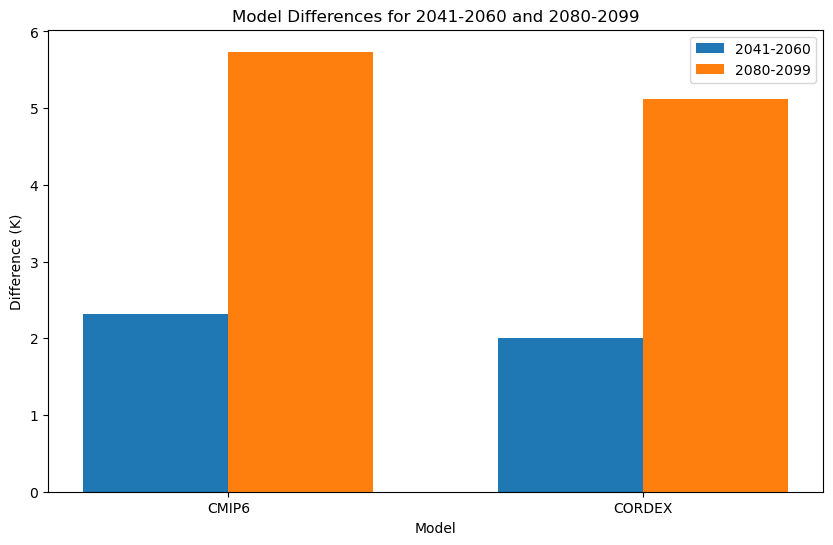

In [45]:
CMIP6_overall_baseline = CMIP6_baseline.collapsed('time', iris.analysis.MEAN)
CMIP6_overall_baseline = CMIP6_overall_baseline.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
CORDEX_overall_baseline = CORDEX_baseline.collapsed('time', iris.analysis.MEAN)
CORDEX_overall_baseline = CORDEX_overall_baseline.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)


# Averages
def calculate_overall_mean(cubelist):
    averages = []
    for cube in cubelist:
        cube = cube.collapsed('time', iris.analysis.MEAN)
        cube = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
        averages.append(cube.data)
    model_average = np.mean(averages)
    print(f"Model average: {model_average}")
    return model_average

CMIP6_2041_2060_average = calculate_overall_mean(CMIP6_2041_2060_cubelist)
CMIP6_2080_2099_average = calculate_overall_mean(CMIP6_2080_2099_cubelist)

CORDEX_2041_2060_average = calculate_overall_mean(CORDEX_2041_2060_cubelist)
CORDEX_2080_2099_average = calculate_overall_mean(CORDEX_2080_2099_cubelist)

# Differences
CMIP6_2041_2060_difference = CMIP6_2041_2060_average - CMIP6_overall_baseline.data
CMIP6_2080_2099_difference = CMIP6_2080_2099_average - CMIP6_overall_baseline.data

CORDEX_2041_2060_difference = CORDEX_2041_2060_average - CORDEX_overall_baseline.data
CORDEX_2080_2099_difference = CORDEX_2080_2099_average - CORDEX_overall_baseline.data

print(f"CMIP6 2041-2060 difference: {CMIP6_2041_2060_difference}")
print(f"CMIP6 2080-2099 difference: {CMIP6_2080_2099_difference}")
print(f"CORDEX 2041-2060 difference: {CORDEX_2041_2060_difference}")
print(f"CORDEX 2080-2099 difference: {CORDEX_2080_2099_difference}")

# Define the models and periods
models = ["CMIP6", "CORDEX"]
periods = ["2041-2060", "2080-2099"]

# Define the data for each model and period
data = {
    "CMIP6": [CMIP6_2041_2060_difference, CMIP6_2080_2099_difference],
    "CORDEX": [CORDEX_2041_2060_difference, CORDEX_2080_2099_difference]
}

# Calculate the number of models and periods to plot, creatd
n_models = len(models)
n_periods = len(periods)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width and positions of the bars
bar_width = 0.35

index = np.arange(n_models)

# Plot the bars for each period
for i, period in enumerate(periods):
    values = [data[model][i] for model in models]
    ax.bar(index + i * bar_width, values, bar_width, label=period)

# Set the x-axis labels to the models (otherwise just numbers)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Difference (K)')
ax.set_title('Model Differences for 2041-2060 and 2080-2099')
ax.legend()

# Show the plot
plt.show()